In [1]:
import tensorflow as tf
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import mplfinance as mpf
import talib as talib
import numpy as np
import data as ds
import common as common
import os as os
import math as math
import datetime as datetime
import scipy as sp
from os import listdir, walk
from itertools import repeat
from mplfinance.original_flavor import candlestick_ohlc
from datetime import datetime, timedelta
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, pairwise, mean_squared_error, mean_absolute_error
from scipy import stats

In [2]:
# 0.1 环境设定
pd.options.mode.chained_assignment = None

# 0.2 不让程序占满 GPU 内存
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# 1.0 重構數據集
def reshape_dataframe(df0):
    df0.fillna(0, inplace=True)
    df0.replace([np.inf, -np.inf], 0, inplace=True)
    df0.columns = ['udate', 'High', 'Low', 'Open', 'Close', 'Volume']
    types2 = {'udate': 'object', 'High': 'float64', 'Low': 'float64', 'Open': 'float64', 'Close': 'float64', 'Volume': 'int64'}
    df0.astype(types2).dtypes
    df0_1 = df0.copy(deep=True)
    error_row = []
    for k, v in df0.iterrows():
        if not pd.isnull(df0['udate'].iloc[k]) and df0['udate'].iloc[k] > 0:
            stime = str(int(df0['udate'].iloc[k]))
            df0_1['udate'].iloc[k] = datetime(year=2020, month=int(stime[-8:-6]), day=int(stime[-6:-4]), hour=int(stime[-4:-2]), minute=int(stime[-2:]), second=0)
        else:
            error_row.append(k)
    df0_1.drop(df0_1.index[error_row], inplace=True)
    df0_1.udate = pd.to_datetime(df0_1.udate)
    df0_1.index = pd.to_datetime(df0_1.udate)
    
    # 1.0.1 數據有效性檢查
    for k, v in types2.items():
        if (df0_1[k].isin([np.nan]).any().any()):
            print(k+' obtains nan')
        if (df0_1[k].isin([0]).any().any()):
            print(k+' obtains 0')
    is_contain_null = df0_1.isnull().sum()
    
    # 1.0.2
    return df0_1

# 1.1 数据源
files = []
file_1 = os.path.abspath(os.path.join('data', 'nq', 'nq-20201105.csv'))
df1_1 = reshape_dataframe(pd.read_csv(file_1))
files.append(df1_1)

file_2 = os.path.abspath(os.path.join('data', 'nq', 'nq-20201105_Aug_Sep.csv'))
df1_2 = reshape_dataframe(pd.read_csv(file_2))
files.append(df1_2)

file_3 = os.path.abspath(os.path.join('data', 'nq', 'nq-20201110.csv'))
df1_3 = reshape_dataframe(pd.read_csv(file_3))
files.append(df1_3)

file_4 = os.path.abspath(os.path.join('data', 'nq', 'nq-20201111.csv'))
df1_4 = reshape_dataframe(pd.read_csv(file_4))
files.append(df1_4)

df2 = pd.concat(files, ignore_index=False)

# 1.2 刪除重覆index
df2 = df2.groupby(df2.index).first()

# 1.3 排序
df2.sort_index(axis=0, ascending=True, inplace=True)
df3 = df2.copy(deep=True)
df3

Volume obtains 0
Volume obtains 0
Volume obtains 0
Volume obtains 0


,udate,High,Low,Open,Close,Volume
udate,,,,,,
2020-08-02 17:01:00,2020-08-02 17:01:00,10911.0,10911.0,10911.0,10911.0,0.0
2020-08-02 17:02:00,2020-08-02 17:02:00,10911.0,10911.0,10911.0,10911.0,0.0
2020-08-02 17:03:00,2020-08-02 17:03:00,10911.0,10911.0,10899.0,10899.0,1.0
2020-08-02 17:04:00,2020-08-02 17:04:00,10899.0,10902.0,10899.0,10902.0,3.0
2020-08-02 17:05:00,2020-08-02 17:05:00,10902.0,10902.0,10902.0,10902.0,0.0
...,...,...,...,...,...,...
2020-11-10 16:55:00,2020-11-10 16:55:00,11624.0,11624.0,11624.0,11624.0,0.0
2020-11-10 16:56:00,2020-11-10 16:56:00,11624.0,11624.0,11624.0,11624.0,0.0
2020-11-10 16:57:00,2020-11-10 16:57:00,11624.0,11624.0,11624.0,11624.0,0.0


In [4]:
# 2.0 技術指標
highs = np.array(df3['High'], dtype='float')
lows = np.array(df3['Low'], dtype='float')
opens = np.array(df3['Open'], dtype='float')
closes = np.array(df3['Close'], dtype='float')
vols = np.array(df3['Volume'], dtype='float')
# 2.1 SMA 均線
for v in [5, 40, 80, 120]:
    df3['sma-'+str(v)]= talib.SMA(closes, timeperiod=v)
# 2.2 Bollinger 保力加
df3['upper-band'], df3['middle-band'], df3['lower-band'] = talib.BBANDS(closes, timeperiod=20*1.5, nbdevup=2, nbdevdn=2, matype=0)
# 2.3 %B %保力加
df3['%b'] = (df3['Close']-df3['lower-band'])/(df3['upper-band']-df3['lower-band'])*100
df3['%b-high']  = common.percentB_belowzero(df3['%b'], df3['Close']) 
df3['%b-low'] = common.percentB_aboveone(df3['%b'], df3['Close'])
# 2.4 OBV 能量潮
df3['obv'] = talib.OBV(closes, vols)
# 2.5 VOL EMA
df3['vol-ema5'] = talib.EMA(vols, timeperiod=5*4)
# 2.6 P-SAR 抛物线
df3['p-sar'] = talib.SAR(highs, lows, acceleration=0.02, maximum=0.2)
# 2.7 VWAP 成交量加權平均價格
period = [5, 40, 80, 120]
for v in period:
    df3['typical-price'] = (df3['High'] + df3['Low'] + df3['Close']) / 3
    df3['turnover'] = df3['typical-price'] * df3['Volume']
    df3['cum-turnover-'+str(v)] = df3['turnover'].rolling(window=v).sum()
    df3['cum-volume-'+str(v)] = df3['Volume'].rolling(window=v).sum()
    df3['vwap-'+str(v)] = df3['cum-turnover-'+str(v)] / df3['cum-volume-'+str(v)]
    df3['vwap-'+str(v)] = df3['vwap-'+str(v)].replace([np.inf, -np.inf], 0)
    df3['vwap-'+str(v)].fillna(0, inplace=True)
    drop_list_1 = ['turnover', 'typical-price', 'cum-turnover-'+str(v), 'cum-volume-'+str(v)]
    df3.drop(drop_list_1, axis=1, inplace=True)
# 2.8 MACD
df3['macd'], df3['macdsignal'], df3['macdhist'] = talib.MACD(closes, fastperiod=12, slowperiod=26, signalperiod=9*40)
# 2.9 KDJ
df3['k-kdj'], df3['d-kdj'], df3['j-kdj'] = common.kdj(highs, lows, closes, window_size=20)
df3['diff-kdj'] = df3['k-kdj']-df3['d-kdj']
df3['j-kdj'].loc[((df3['j-kdj'] > 20) & (df3['j-kdj'] < 100))] = 0

In [5]:
# 3.0 separate to daily
data = {}
days1 = list(dict.fromkeys([v.date() for v in df3['udate']])) # how many tradeing day
for day in days1:
    day_start = datetime(day.year, day.month, day.day, 5, 0, 0)
    day2 = day + timedelta(days=1)
    day_end = datetime(day2.year, day2.month, day2.day, 3, 55, 0)
    mask = ((df3['udate'] >= day_start) & (df3['udate'] <= day_end))
    df4 = df3.loc[mask]
    if (df4.shape[0] > 1):
        data[day] = df4

In [6]:
# 4.0 draw chart
drop_list_2 = []
for k, _df5 in data.items():
    df5 = _df5.copy(deep=True)
    # 4.1 style
    style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size':6})
    # 4.2 addplot
    apds = [mpf.make_addplot(df5['lower-band'],panel=0,color='orange',linestyle='solid'),
            mpf.make_addplot(df5['upper-band'],panel=0,color='bisque',linestyle='solid'),
            mpf.make_addplot(df5['vwap-40'].replace(0, np.nan),panel=0,color='aqua',linestyle='solid'),
            mpf.make_addplot(df5['%b-low'],type='scatter',markersize=20,marker='v',panel=0),
            mpf.make_addplot(df5['%b-high'],type='scatter',markersize=20,marker='^',panel=0),
            mpf.make_addplot(df5['p-sar'],scatter=True,markersize=1,marker='*',panel=0,color='blueviolet'),
            #
            mpf.make_addplot(df5['vol-ema5'],panel=1,color='orange'),
            #
            mpf.make_addplot(df5['macd'],panel=2,color='orange'),
            mpf.make_addplot(df5['macdsignal'],panel=2,color='violet'),
            mpf.make_addplot(df5['macdhist'],panel=2,type='bar',color='dimgray'),
            #
            mpf.make_addplot(df5['k-kdj'],panel=3,color='orange'),
            mpf.make_addplot(df5['d-kdj'],panel=3,color='violet'),
            mpf.make_addplot(df5['j-kdj'],panel=3,color='aqua'),
            mpf.make_addplot(df5['diff-kdj'],panel=3,type='bar',color='dimgray')]
    # 4.3 render
    if (False):
        try:
            print(df5.shape, df5['udate'].iloc[0], df5['udate'].iloc[-1])
            mpf.plot(df5, type='candle', addplot=apds, style=style, ylabel='', ylabel_lower='', volume=True, figscale=0.75, xrotation=0, datetime_format="%H:%M", show_nontrading=False, tight_layout=True, savefig='./data/img-nq/features/'+k.strftime('%m-%d-%Y')) 
        except:
            drop_list_2.append(k)
    # 4.4 drop err day
    elif df5['Volume'].shape[0] == df5['Volume'].isin([0]).sum():
        drop_list_2.append(k)

# ERROR: 10-29 & 10-30
for k in drop_list_2:
    data.pop(k, None)
    print('excpet & delete: ', k)

excpet & delete:  2020-10-29
excpet & delete:  2020-10-30


In [7]:
# 5.0 合併
df7 = pd.DataFrame()
for k, df6 in data.items():
    df7 = pd.concat([df7, df6], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

# 5.1 清洗
df8 = df7.copy(deep=True)
drop_list_3 = ['udate', 'High', 'Low', 'Open', 'Volume', 'obv', 'sma-5', 'sma-80', 'vwap-5', 'vwap-80', 'macd', 'macdsignal', 
               'middle-band', 'k-kdj', 'd-kdj']
df8.drop(drop_list_3, axis=1, inplace=True)
df8.fillna(0, inplace=True)
df8 = df8.round(2)

# 5.2 檢查
is_contain_null = df8.isnull().sum()
is_contain_nan = df8.isna().sum()
is_contain_inf = df8.isin([np.nan]).sum()
print('数据集: Total dataset has {} samples, and {} features.'.format(df8.shape[0], df8.shape[1])) # df8.info()
    
# 5.4 儲存
path_data = os.path.abspath(os.path.join('data', 'nq', 'nq-clean-data-with-features.csv'))
if os.path.exists(path_data):
    os.remove(path_data)
df8.to_csv(path_data)

# 5.3 正則化
min_max_scaler, standar_scaler = MinMaxScaler(feature_range=(-0.99, 0.99)), StandardScaler()
_df8 = min_max_scaler.fit_transform(df8)
df8 = pd.DataFrame(_df8, columns=df8.columns, index=df8.index)

# 5.5 分包
no_day = np.array([v.shape[0] for k, v in data.items()])
no_day_1, no_day_2, no_day_3 = no_day[:-25].sum(), no_day[:-16].sum(), no_day.sum()
train_data = df8.iloc[200 : no_day_1]
test_data = df8.iloc[no_day_1 : no_day_2]
validation_data = df8.iloc[no_day_2 : no_day_3]
print('分包: Train Data: {}, Test Data: {}, Validation Data: {}'.format(train_data.shape, test_data.shape, validation_data.shape))

# 5.6 輸入層數據
def split_data_v2(data, timesteps, t_pus_no):
    x_data, y_data = [], []
    no_max = data.shape[0]-t_pus_no
    for i in range(timesteps, no_max):
        start, end = i-timesteps, i
        temp_0 = data.iloc[end: end+t_pus_no]
        y_data.append(temp_0['Close'].tail(1))
        temp_1 = data.iloc[start: end]
        x_data.append(temp_1)
    x_data, y_data = np.array(x_data), np.array(y_data)
    return [x_data, y_data]

# 5.7 窗口步長
t_pus_no = 1
window_size_1 = 45
window_size_2 = 45
x_train, y_train = split_data_v2(train_data, window_size_1, t_pus_no)
x_test, y_test = split_data_v2(test_data, window_size_1, t_pus_no)
x_valid, y_valid = split_data_v2(validation_data, window_size_2, t_pus_no)

# no_batches, timesteps, no_features
print('訓練集: X_train Data: {}, Y_train Data: {}'.format(x_train.shape, y_train.shape))
print('測試集: X_Test Data: {}, Y_Test Data: {}'.format(x_test.shape, y_test.shape))
print('验证集: X_Valid Data: {}, Y_Valid Data: {}'.format(x_valid.shape, y_valid.shape))

数据集: Total dataset has 93818 samples, and 15 features.
分包: Train Data: (65922, 15), Test Data: (10123, 15), Validation Data: (17573, 15)
訓練集: X_train Data: (65876, 45, 15), Y_train Data: (65876, 1)
測試集: X_Test Data: (10077, 45, 15), Y_Test Data: (10077, 1)
验证集: X_Valid Data: (17527, 45, 15), Y_Valid Data: (17527, 1)


In [8]:
# 6.1.1 模型参数
batch_size = 512
epochs = 2
units = 1024
verbose = 1
no_batches = x_train.shape[0]
timesteps = x_train.shape[1]
no_features = x_train.shape[2]
batch_input_shape = (timesteps, no_features)

# 6.1.2 日志参数
prefix = 'nq-lstm'
cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# 6.2 模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=units, recurrent_activation='sigmoid', activation='tanh', unroll=False, use_bias=True, 
                               recurrent_dropout=0, return_sequences=True, input_shape=batch_input_shape))
model.add(Dropout(rate=0.20))
model.add(tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=batch_input_shape))
model.add(Dropout(rate=0.20))
model.add(tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=batch_input_shape))
model.add(Dropout(rate=0.10))
model.add(tf.keras.layers.LSTM(units=units, return_sequences=False, input_shape=batch_input_shape))
model.add(Dropout(rate=0.10))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

# 6.3.1 check point
checkpoint_dir = './training_checkpoints/'+ prefix +'-' + cur_time
os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

# 6.3.2 tensor board
log_dir = os.path.join('./logs/fit/'+ prefix +'-') + cur_time
os.mkdir(log_dir)
tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 6.4 fit model
history_model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True,
                          verbose=verbose, callbacks=[checkpoint_callback, tensor_board_callback])

# 6.5 save model
model_path = "./saved_model/"+prefix+"-"+cur_time+".h5"
model.save(model_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 1024)          4259840   
_________________________________________________________________
dropout (Dropout)            (None, 45, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 1024)          8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 1024)          8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              8

In [9]:
# 7.1 visualize loss
keys = list(history_model.history.keys())
training_loss = history_model.history['loss']
test_loss = history_model.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('model:'+prefix+'   batch_size:'+str(batch_size)+'   epochs:'+str(epochs)+'   units:'+str(units),loc ='left')
plt.tight_layout()
plt.grid()
plt.savefig('./data/img-nq/results/'+cur_time+'-loss')
plt.clf()

# 7.2 visualize accuracy
training_accuracy = history_model.history['accuracy']
test_accuracy = history_model.history['val_accuracy']
epoch_count = range(1, len(training_accuracy) + 1)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('model:'+prefix+'   batch_size:'+str(batch_size)+'   epochs:'+str(epochs)+'   units:'+str(units),loc ='left')
plt.tight_layout()
plt.grid()
plt.savefig('./data/img-nq/results/'+cur_time+'-accuracy')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [10]:
# 8.0 model evaluate
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (train_score[0], math.sqrt(train_score[0])))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (test_score[0], math.sqrt(test_score[0])))
valid_score = model.evaluate(x_valid, y_valid, verbose=0)
print('Validate Score: %.4f MSE (%.4f RMSE)' % (valid_score[0], math.sqrt(valid_score[0])))

Train Score: 0.0028 MSE (0.0530 RMSE)
Test Score: 0.0022 MSE (0.0469 RMSE)
Validate Score: 0.0023 MSE (0.0477 RMSE)


          nobs                minmax          mean       variance  skewness  \
real     17527    (10943.5, 12405.5)  11613.690577  106308.871661  0.116801   
predict  17527  (11025.91, 12311.68)  11609.550476   83998.802412  0.159030   

         kurtosis        r2          mse       rmse        mae    ampe  
real    -0.442318  0.983021  1804.931561  42.484486  32.563511  0.0028  
predict -0.399074  0.983021  1804.931561  42.484486  32.563511  0.0028  


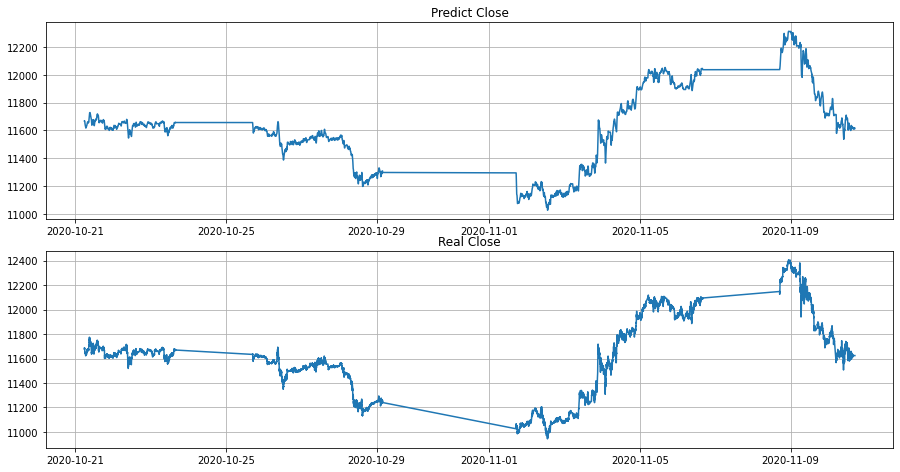

<Figure size 432x288 with 0 Axes>

In [11]:
# 9.0 prediction
predict1 = model.predict(x_valid)

# 9.1 inverse
len_shape_y = x_valid.shape[2]-1
fill_list = list(repeat(0, len_shape_y))
predict2 = [[v[0]] + fill_list for v in predict1]
close2 = [[v[0]] + fill_list for v in y_valid]

predict3 = min_max_scaler.inverse_transform(predict2)
close3 = min_max_scaler.inverse_transform(close2)

predict4 = [v[0] for v in predict3]
close4 = [v[0] for v in close3]

# 9.2 rehsape dataframe
df9 = pd.DataFrame({'predict_close': predict4, 'real_close': close4})
df9.index = validation_data.iloc[-df9.shape[0]-1:-1].index

# 9.3.1 stats evaluate
df9 = df9.round(2)
stats_1 = stats.describe(df9['real_close'].values)
stats_2 = stats.describe(df9['predict_close'].values)
r2 = r2_score(df9['real_close'].values, df9['predict_close'].values)
mse = mean_squared_error(df9['real_close'].values, df9['predict_close'].values)
rmse = np.sqrt(mean_squared_error(df9['real_close'].values, df9['predict_close'].values))
mae =  mean_absolute_error(df9['real_close'].values, df9['predict_close'].values)
ampe = np.mean(np.abs((df9['real_close']-df9['predict_close'])/df9['real_close']))
# R平方, 均方误差, 均方根误差, 平均绝对误差, 平均絕對百分比誤差
columns2 = ['r2', 'mse', 'rmse', 'mae', 'ampe']
result1 = [r2, mse, rmse, mae, ampe]
df12 = pd.DataFrame([list(stats_1)+result1, list(stats_2)+result1], columns=list(stats_1._fields)+columns2, index=['real', 'predict'])

# 9.3.2 save stats evaluate
path_3 = os.path.abspath(os.path.join('data', 'img-nq', 'prediction', 'nq-prediction-'+cur_time+'.csv'))
if os.path.exists(path_3):
    os.remove(path_3)
df12.to_csv(path_3)
print(df12)

# 9.4 combine
df10 = df7.drop(list(df7.columns)[6:], axis=1)
df11 = pd.concat([df10, df9], axis=1)
df11 = df11.tail(df9.shape[0]+window_size_1+t_pus_no)

# 9.5.1 chart1
fig, axs = plt.subplots(2)
fig.set_size_inches(12.5, 6.5)
fig.tight_layout()
axs[0].plot(df11.index, df11['predict_close'])
axs[1].plot(df11.index, df11['real_close'])
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_title('Predict Close')
axs[1].set_title('Real Close')

path_2 = os.path.abspath(os.path.join('data', 'img-nq', 'prediction', 'nq-prediction-'+cur_time+'.jpg'))
if os.path.exists(path_2):
    os.remove(path_2)
plt.savefig(path_2)
plt.show()
plt.clf()

# 9.6 save
path_1 = os.path.abspath(os.path.join('data', 'nq', 'nq-prediction.csv'))
if os.path.exists(path_1):
    os.remove(path_1)
df11 = df11.drop(['udate', 'real_close'], axis=1)
df11.to_csv(path_1)